Q. is the decoding accuracy better for expected vs unexpected trials?

Methods:
1. apply NPS ROI mask
2. extract patterns and classify based on expect/unexpect trials
3. calcualate accuracy and f1 scores
4. 




In [101]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py


from nilearn import image, masking, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker


import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nntdata

from surfplot import Plot
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline



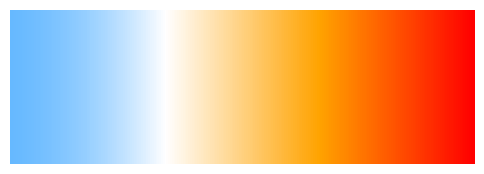

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
# Define the colors at specific points
colors = [
    # (0, "#120041"),  # Start with blue at -1.9
    # (0, "#2500fa"),
    (0, "#84c6fd"),  # Start with blue at -1.9
    (0.33, "white"),    # Transition to white at 0
    (0.6, "#ffa300"),
    # (0.4, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (0, to_rgba("#120041", alpha=1.0)),  # Fully opaque
    # (0, to_rgba("#2500fa", alpha=0.8)),  # Fully opaque
    (0, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0.33, to_rgba("white", alpha=1.0)),       # Fully opaque
    (0.6, to_rgba("#ffa300", alpha=1.0)),   # 30% opacity
    # (0.4, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.0, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, 1, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()



## load nifti files

`scripts/step12_multiclass/mask_singletrial.py` <br>
`scripts/step12_multiclass/mask_singletrial.sh`

# load data

In [22]:
# once the voxels values are extracted
data_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv02_parcel-NPS'
npy_nps = np.load(join(data_dir, "npspos_dACC_event-stimulus.npy"))
npy_nps_metadata = join(data_dir, "npspos_dACC_event-stimulus.json")
with open(npy_nps_metadata, 'r') as file:
    npy_nps_meta = json.load(file)
# feed it through the SVM pipeline

In [23]:
# load numpy
# load json file with metadata

# combine as pandas
# npsneg_lLOC = np.vstack(masked_niftiarray)
npsneg_lLOC = npy_nps
singletrial_fname = npy_nps_meta['filenames']
npspos_dACCdf = pd.DataFrame({'singletrial_fname': singletrial_fname})

def extract_metadata(filename):
    pattern = re.compile(
        r"(?P<sub>sub-\d+)_"
        r"(?P<ses>ses-\d+)_"
        r"(?P<run>run-\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"(?P<trial>trial-\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimulusintensity>\w+)"
    )
    match = pattern.search(filename)
    if match:
        
        metadata = match.groupdict()
        metadata['cue'] = metadata['cuetype'] + '_cue'
        metadata['stim'] = metadata['stimulusintensity'] + '_stim'
        return metadata
    
    return {}
metadata_df = pd.DataFrame(npspos_dACCdf['singletrial_fname'].apply(extract_metadata).tolist())
metadata_df = pd.concat([metadata_df, npspos_dACCdf], axis=1)


prefix = "NPSpos_dACC_"
columns = [prefix + str(i) for i in range(npsneg_lLOC.shape[1])]
arraydf = pd.DataFrame(npsneg_lLOC, columns=columns)

npspos_dACCdf = pd.concat([metadata_df, arraydf], axis=1)

In [24]:
npspos_dACCdf

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dACC_172,NPSpos_dACC_173,NPSpos_dACC_174,NPSpos_dACC_175,NPSpos_dACC_176,NPSpos_dACC_177,NPSpos_dACC_178,NPSpos_dACC_179,NPSpos_dACC_180,NPSpos_dACC_181
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,1.388228,0.904351,-0.255798,-0.263679,-0.030048,0.071986,0.888774,0.464462,1.214903,0.777590
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,-0.238658,-0.336323,0.301502,-0.011044,0.134401,-0.113778,-0.072287,-0.104584,-0.412053,-0.478856
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.650335,0.942116,0.510449,0.730210,0.573041,0.723064,0.386306,0.541142,0.559737,0.767509
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,0.182327,0.333341,0.120561,-0.026085,0.106933,-0.019725,-0.143775,-0.050420,-0.166975,-0.173536
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,0.803049,0.759632,-0.189801,-0.150728,-0.156958,-0.084024,0.305832,0.234135,0.815478,0.763881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17106,sub-0133,ses-04,run-02,pain,stimulus,trial-008,high,high,high_cue,high_stim,...,0.471998,0.731039,0.210806,0.236812,0.192283,0.302114,0.194005,0.279914,0.516217,0.705958
17107,sub-0133,ses-04,run-03,vicarious,stimulus,trial-008,low,med,low_cue,med_stim,...,0.539269,0.826191,0.239379,-0.022515,0.204048,0.103741,0.544395,0.593226,0.824838,0.948978
17108,sub-0133,ses-03,run-04,cognitive,stimulus,trial-000,high,low,high_cue,low_stim,...,1.271826,2.075302,0.572015,0.459538,0.913633,0.773790,1.183248,1.478207,1.582399,2.033468
17109,sub-0133,ses-03,run-05,vicarious,stimulus,trial-001,high,med,high_cue,med_stim,...,0.427253,0.620623,0.243672,-0.080139,0.145775,0.039234,0.283725,0.347326,0.566183,0.712040


In [25]:
# Define the mapping
mapping = {'low_stim': 0, 'med_stim': 1, 'high_stim': 2}
npspos_dACCdf['stim_num'] = npspos_dACCdf['stim'].map(mapping)


# dACC average activation

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

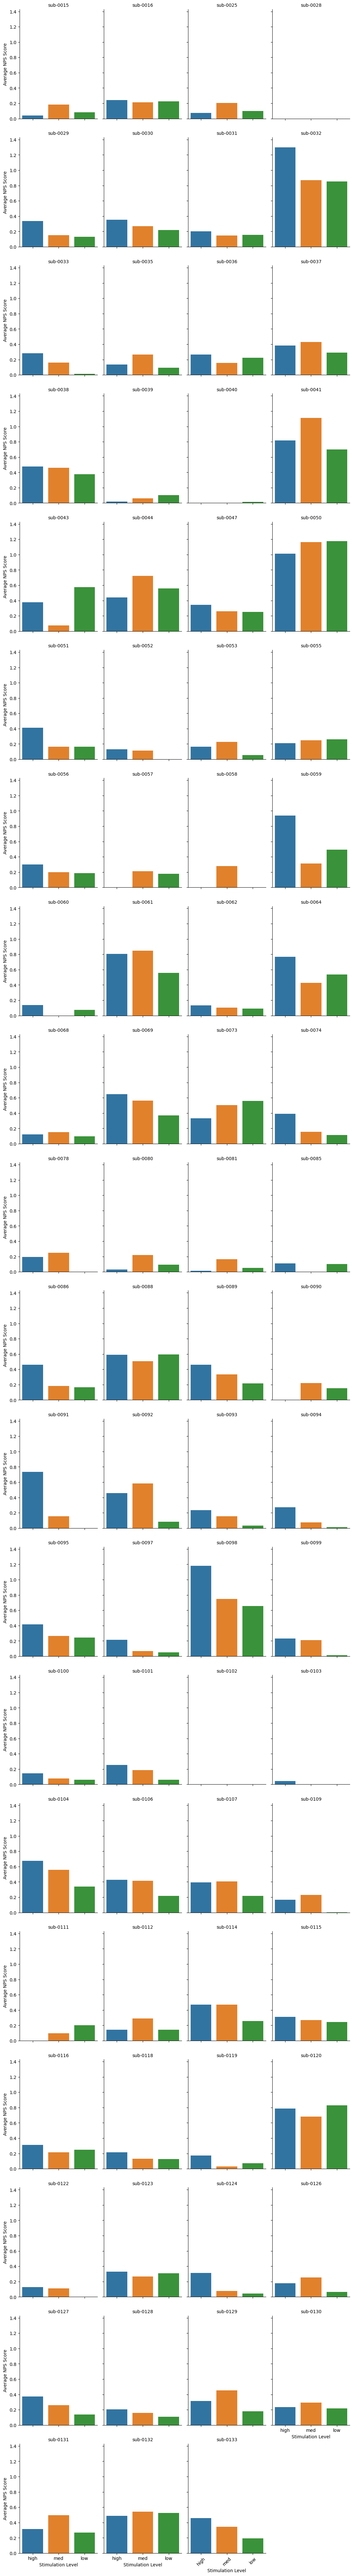

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cuetype='high_cue'
df_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') &
                                    (npspos_dACCdf['ses'] == 'ses-01')
                                    # (npspos_dACCdf['cue'] == cuetype) 
                                    ].index
df_pain = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') &
                                ((npspos_dACCdf['ses'] == 'ses-01')) 
                                # (npspos_dACCdf['cue'] == cuetype)
                                ].copy().reset_index(drop=True)

# Step 1: Compute the row-wise mean of the NPS scores
df_pain['NPS_mean'] = df_pain.filter(regex=r'^NPSpos_dACC_\d+').mean(axis=1)

# Step 2: Aggregate data to compute the mean NPS score per 'stim' for each 'sub'
grouped_data = df_pain.groupby(['sub', 'stimulusintensity'])['NPS_mean'].mean().reset_index()

# Step 3: Adjust order of 'stim' levels
stim_order = ['high', 'med', 'low']
grouped_data['stimulusintensity'] = pd.Categorical(grouped_data['stimulusintensity'], categories=stim_order, ordered=True)

# Now, grouped_data is ready for plotting
# Step 4: Plot
g = sns.catplot(x='stimulusintensity', y='NPS_mean', col='sub', data=grouped_data, kind='bar',
                height=4, aspect=.7, col_wrap=4, order=stim_order)

# Optional: Adjust plot aesthetics
g.set_axis_labels("Stimulation Level", "Average NPS Score")
g.set_titles("{col_name}")
g.set(ylim=(0, grouped_data['NPS_mean'].max()*1.1)) # Adjust y-axis limits if necessary
plt.xticks(rotation=45) # Rotate x-axis labels if needed

plt.show()


## expected vs unexpected

In [153]:
ratings.columns

Index(['sub', 'ses', 'run', 'runtype', 'trial_index', 'cue',
       'stimulusintensity', 'singletrial_fname', 'expectrating', 'expectlabel',
       'outcomerating', 'outcomelabel'],
      dtype='object')

In [198]:
ratings = pd.read_csv('/Users/h/Documents/projects_local/cue_expectancy/data/beh/sub-all_task-all_events.tsv', sep = '\t')
ratings

def parse_filename_with_regex_adjusted(filename):
    # Updated regular expression pattern to keep the prefixes in the extracted values
    pattern = r"(sub-\d+)_(ses-\d+)_(run-\d+)_runtype-(\w+)_event-(\w+)_trial-(\d+)_cuetype-(\w+)_stimintensity-(\w+)"
    match = re.match(pattern, filename)
    
    if match:
        metadata = {
            'sub': match.group(1),  # Keeping the prefix for sub
            'ses':  match.group(2),  # Adding 'ses-' prefix
            'run':  match.group(3),  # Adding 'run-' prefix
            'runtype': match.group(4),
            'event': match.group(5),
            'trial_index': int(match.group(6)),  # Convert trial_index to integer
            'cue': match.group(7) + '_cue',  # Append "_cue" to cue value
            'stimulusintensity': match.group(8),  # Append "_stim" to stimulusintensity value
        }
        return metadata
    else:
        return {}

# Test the adjusted function with the sample filename
ratings_parsed = (ratings['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
rating_merge = pd.concat([ratings[['singletrial_fname', 'expectrating', 'outcomerating']], ratings_parsed], axis=1)

npspos_dACCdf['trial_index'] = npspos_dACCdf['trial'].str.extract('(\d+)').astype(int)

brain_metadf = pd.merge(rating_merge, npspos_dACCdf, on=[ "sub", "ses", "run", "runtype", "trial_index", "cue", "stimulusintensity"], how="inner")

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

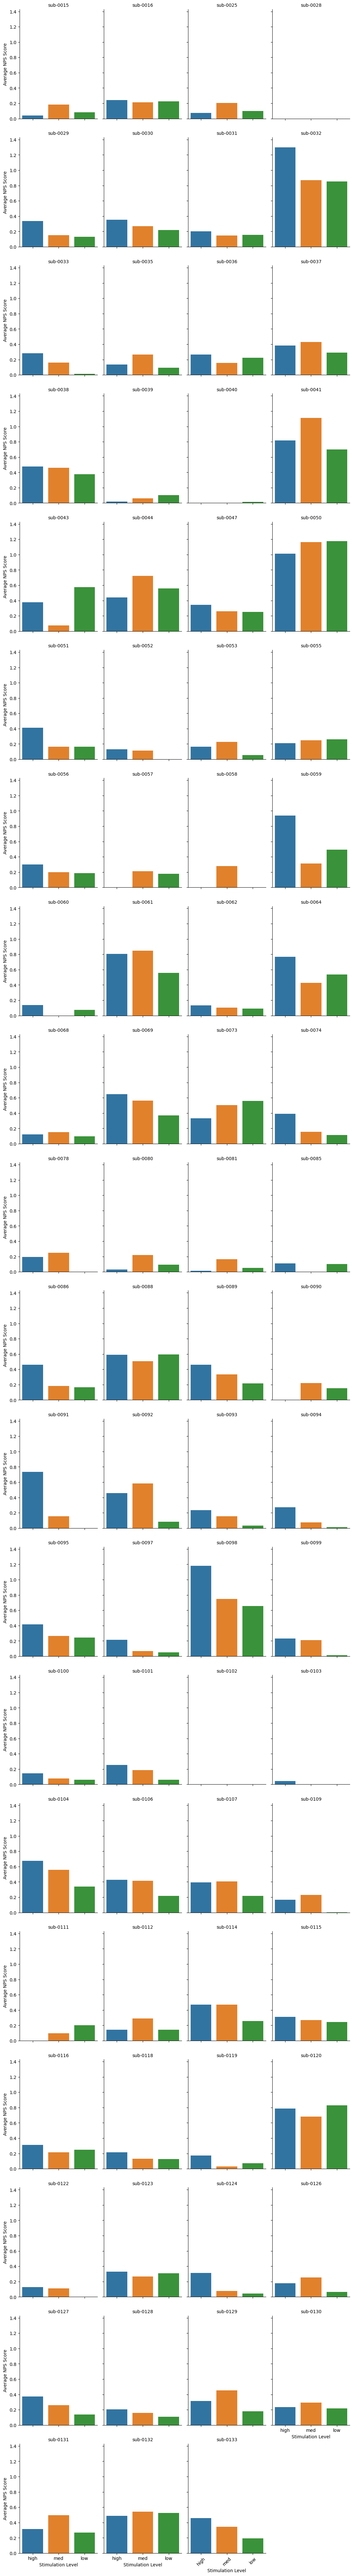

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot stimulus intensity based on expected stimulus
brain_metadf['PE'] = brain_metadf['outcomerating'] - brain_metadf['expectrating'] 
# filtered_df = brain_metadf[brain_metadf['PE'] <=0]
filtered_df = brain_metadf
df_pain_index = filtered_df[(filtered_df['runtype'] == 'pain') &
                                    (filtered_df['ses'] == 'ses-01')
                                    # (npspos_dACCdf['cue'] == cuetype) 
                                    ].index
df_pain = filtered_df[(filtered_df['runtype'] == 'pain') &
                                ((filtered_df['ses'] == 'ses-01')) 
                                # (npspos_dACCdf['cue'] == cuetype)
                                ].copy().reset_index(drop=True)

# Step 1: Compute the row-wise mean of the NPS scores
df_pain['NPS_mean'] = df_pain.filter(regex=r'^NPSpos_dACC_\d+').mean(axis=1)

# Step 2: Aggregate data to compute the mean NPS score per 'stim' for each 'sub'
grouped_data = df_pain.groupby(['sub', 'stimulusintensity'])['NPS_mean'].mean().reset_index()

# Step 3: Adjust order of 'stim' levels
stim_order = ['high', 'med', 'low']
grouped_data['stimulusintensity'] = pd.Categorical(grouped_data['stimulusintensity'], categories=stim_order, ordered=True)

# Now, grouped_data is ready for plotting
# Step 4: Plot
g = sns.catplot(x='stimulusintensity', y='NPS_mean', col='sub', data=grouped_data, kind='bar',
                height=4, aspect=.7, col_wrap=4, order=stim_order)

# Optional: Adjust plot aesthetics
g.set_axis_labels("Stimulation Level", "Average NPS Score")
g.set_titles("{col_name}")
g.set(ylim=(0, grouped_data['NPS_mean'].max()*1.1)) # Adjust y-axis limits if necessary
plt.xticks(rotation=45) # Rotate x-axis labels if needed

plt.show()


# svm: highcue

sub-0005 number of trials: 24
sub-0013 number of trials: 24
sub-0014 number of trials: 24
sub-0015 number of trials: 12
sub-0016 number of trials: 28
sub-0017 number of trials: 12
sub-0018 number of trials: 24
sub-0019 number of trials: 18
sub-0021 number of trials: 24
sub-0025 number of trials: 36
sub-0026 number of trials: 24
sub-0028 number of trials: 12
sub-0029 number of trials: 36
sub-0030 number of trials: 12
sub-0031 number of trials: 36
sub-0032 number of trials: 32
sub-0033 number of trials: 36
sub-0035 number of trials: 24
sub-0036 number of trials: 36
sub-0037 number of trials: 36
sub-0038 number of trials: 35
sub-0039 number of trials: 24
sub-0040 number of trials: 24
sub-0041 number of trials: 10
sub-0043 number of trials: 33
sub-0044 number of trials: 35
sub-0047 number of trials: 12
sub-0050 number of trials: 23
sub-0051 number of trials: 36
sub-0052 number of trials: 29
sub-0053 number of trials: 36
sub-0055 number of trials: 36
sub-0056 number of trials: 36
sub-0057 n

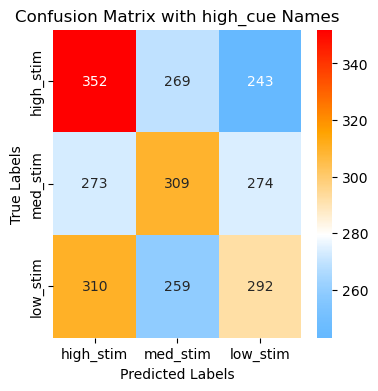

Normalized Confusion Matrix (by Actual Class Totals):
[[0.40740741 0.31134259 0.28125   ]
 [0.31892523 0.36098131 0.32009346]
 [0.36004646 0.30081301 0.33914053]]


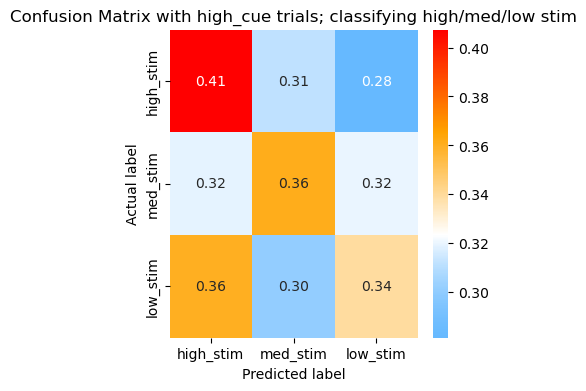

In [139]:
all_Y_test = []
all_Y_pred = []
overall_results = []
# Filter out participants with only one run
cuetype = 'high_cue'
mapping = {'low_stim': 0, 'med_stim': 1, 'high_stim': 2}

# Loop over each subject
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                    (npspos_dACCdf['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                (npspos_dACCdf['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_filtered[df_filtered['sub'] == sub]
    
    # Select corresponding brain data 
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    print(f"{sub} number of trials: {len(Y)}")
    # Perform cross validation with leave-one-run-out scheme
    accuracies = []
    f1_scores = []
    groups = df_sub['run']
    
    cv = GroupKFold(n_splits=len(groups.unique()))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)     
    mean_f1_score = np.mean(f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)
print(results_df)

print(f"intercept: {svm.intercept_}\n classes: {uniques[svm.classes_]} {uniques}")


# _____________ confusion matrix ________________________________________________

# highcue_highmedstim_f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"group average accuracy Score: {results_df.accuracy.mean()}")
print(f"group average F1 Score: {results_df.f1_score.mean()}")

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()


In [136]:
Y_test_remapped
Y_pred_remapped

array([2, 0, 1, ..., 1, 1, 0])

Normalized Confusion Matrix (by Actual Class Totals):


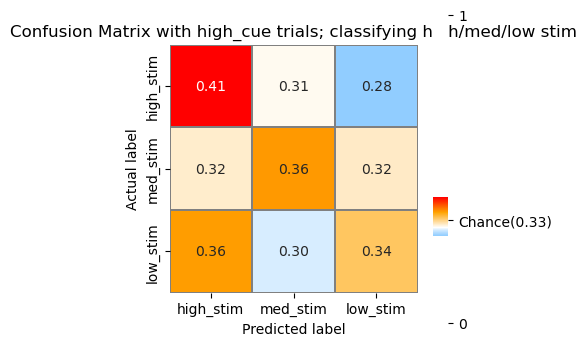

In [140]:
chance_level = 1.0/3
# cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
# print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=cmap, 
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order,
            center=chance_level, linecolor='grey', linewidth=.25, square=True)
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
ax.set_title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, chance_level, 1])
cbar.set_ticklabels(['0', 'Chance(0.33)', '1'])
plt.show()



# svm: lowcue

sub-0005 number of trials: 24
sub-0013 number of trials: 24
sub-0014 number of trials: 24
sub-0015 number of trials: 12
sub-0016 number of trials: 27
sub-0017 number of trials: 12
sub-0018 number of trials: 24
sub-0019 number of trials: 18
sub-0021 number of trials: 24
sub-0025 number of trials: 35
sub-0026 number of trials: 24
sub-0028 number of trials: 12
sub-0029 number of trials: 36
sub-0030 number of trials: 12
sub-0031 number of trials: 36
sub-0032 number of trials: 34
sub-0033 number of trials: 35
sub-0035 number of trials: 22
sub-0036 number of trials: 36
sub-0037 number of trials: 36
sub-0038 number of trials: 36
sub-0039 number of trials: 24
sub-0040 number of trials: 23
sub-0041 number of trials: 12
sub-0043 number of trials: 36
sub-0044 number of trials: 36
sub-0047 number of trials: 12
sub-0050 number of trials: 24
sub-0051 number of trials: 35
sub-0052 number of trials: 30
sub-0053 number of trials: 36
sub-0055 number of trials: 35
sub-0056 number of trials: 36
sub-0057 n

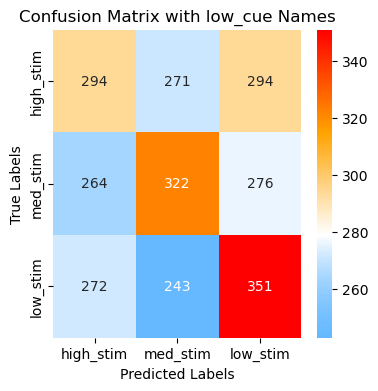

Normalized Confusion Matrix (by Actual Class Totals):
[[0.34225844 0.31548312 0.34225844]
 [0.3062645  0.37354988 0.32018561]
 [0.31408776 0.28060046 0.40531178]]


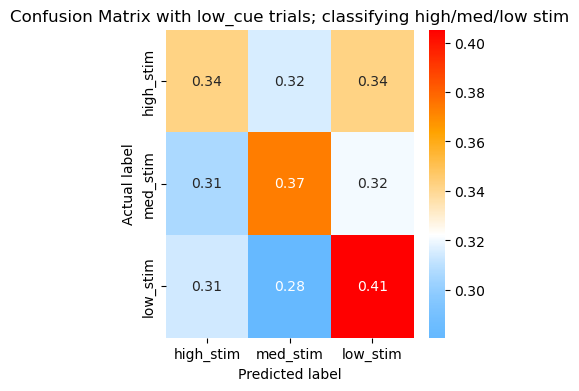

In [141]:
all_Y_test = []
all_Y_pred = []
overall_results = []
# Filter out participants with only one run
cuetype = 'low_cue'
mapping = {'low_stim': 0, 'med_stim': 1, 'high_stim': 2}

# Loop over each subject
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                    (npspos_dACCdf['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                (npspos_dACCdf['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_filtered[df_filtered['sub'] == sub]
    
    # Select corresponding brain data 
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    print(f"{sub} number of trials: {len(Y)}")
    # Perform cross validation with leave-one-run-out scheme
    accuracies = []
    f1_scores = []
    groups = df_sub['run']
    
    cv = GroupKFold(n_splits=len(groups.unique()))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)     
    mean_f1_score = np.mean(f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)
print(results_df)

print(f"intercept: {svm.intercept_}\n classes: {uniques[svm.classes_]} {uniques}")


# _____________ confusion matrix ________________________________________________

# highcue_highmedstim_f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"group average accuracy Score: {results_df.accuracy.mean()}")
print(f"group average F1 Score: {results_df.f1_score.mean()}")

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()


# hyperparameter

In [75]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd

cuetype = 'low_cue'
# Setup your data and groups as before
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    # (npspos_dACCdf['ses'] == "ses-04") &
                                    (npspos_dACCdf['cue'] == cuetype)].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                # (npspos_dACCdf['ses'] == "ses-04") &
                                (npspos_dACCdf['cue'] == cuetype)].copy().reset_index(drop=True)
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [0.1, 1, 10],  # Example hyperparameters
    'svc__kernel': ['linear']  # Adjust as needed
}

# Define the scoring function
scoring = {'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average='weighted')}

overall_results = []

# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])

    groups, _ = pd.factorize(df_sub['run']) # GroupKFold will use this for splitting

    # Setup the pipeline with SVC, now with class_weight='balanced' within SVC
    pipeline = Pipeline([
        ('svc', SVC(kernel='linear', probability=True, class_weight='balanced'))
    ])
    
    # Setup cross-validation method that respects groups
    cv = GroupKFold(n_splits=len(np.unique(groups)))

    # Setup GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='Accuracy', cv=cv, verbose=1)

    # Fit the model
    grid_search.fit(X, Y, groups=groups)

    # Append the best score and best parameters to the overall results
    overall_results.append({
        'sub': sub,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    })

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, tota

In [73]:
uniques

Index(['high_stim', 'low_stim', 'med_stim'], dtype='object')

group average accuracy Score: 0.3817713981924508


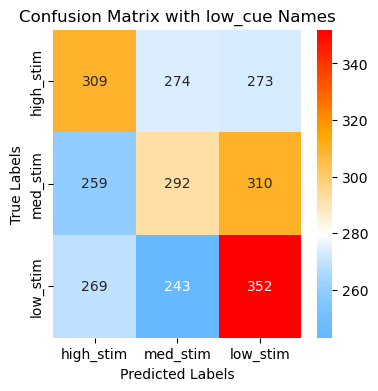

Normalized Confusion Matrix (by Actual Class Totals):
[[0.36098131 0.32009346 0.31892523]
 [0.30081301 0.33914053 0.36004646]
 [0.31134259 0.28125    0.40740741]]


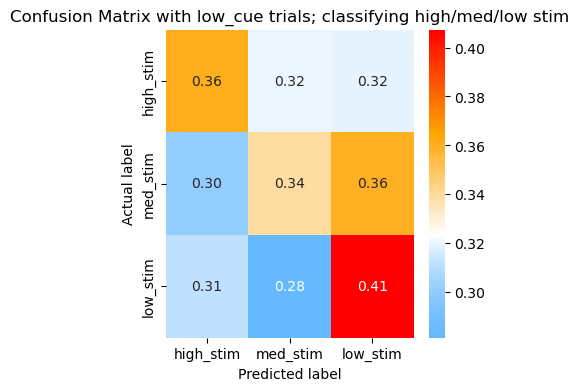

In [78]:

# _____________ confusion matrix ________________________________________________

# highcue_highmedstim_f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"group average accuracy Score: {results_df.best_score.mean()}")
# print(f"group average F1 Score: {results_df.f1_score.mean()}")

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()

# hyperparmaeter v2: low cue

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in 

         sub  accuracy  best_score_avg  \
0   sub-0005  0.291667        0.268519   
1   sub-0013  0.416667        0.306250   
2   sub-0014  0.250000        0.378125   
3   sub-0015  0.250000        0.416667   
4   sub-0016  0.481481        0.383333   
..       ...       ...             ...   
90  sub-0129  0.371429        0.352667   
91  sub-0130  0.416667        0.427333   
92  sub-0131  0.333333        0.444444   
93  sub-0132  0.190476        0.296875   
94  sub-0133  0.388889        0.489333   

                                               y_true  \
0   [0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 2, 2, 0, 1, ...   
1   [0, 1, 2, 1, 0, 2, 1, 2, 1, 0, 0, 2, 1, 1, 0, ...   
2   [2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1, 1, 0, 0, ...   
3                [0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 1, 2]   
4   [0, 1, 0, 0, 0, 2, 1, 2, 2, 1, 0, 0, 1, 2, 2, ...   
..                                                ...   
90  [1, 0, 1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 0, 0, 2, ...   
91  [0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 2, 2

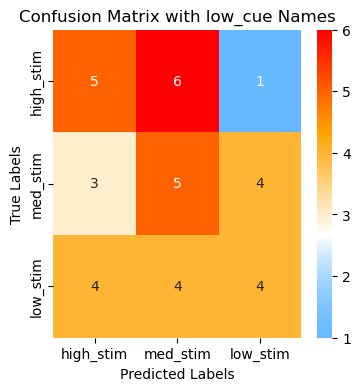

In [126]:
from sklearn.model_selection import GroupKFold, GridSearchCV, check_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score
import numpy as np
import pandas as pd
from warnings import simplefilter
overall_results = []
confusion_matrices = []
cuetype = 'low_cue'
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                    (npspos_dACCdf['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                (npspos_dACCdf['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    groups, _ = pd.factorize(df_sub['run'])
    
    # Define cross-validation at the subject level
    cv = GroupKFold(n_splits=len(np.unique(groups)))  # Or any other number of splits
    cv_splits = cv.split(X, Y, groups)
    
    sub_predictions = []
    sub_true = []
    sub_scores = []
    
    # Outer loop for manual cross-validation
    for train_idx, test_idx in cv_splits:
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced'), 
                                   param_grid, scoring=scoring, refit='Accuracy', cv=len(np.unique(groups)))
        grid_search.fit(X_train, Y_train)
        
        # Best model prediction
        Y_pred = grid_search.predict(X_test)
        
        # Store predictions and true values
        sub_predictions.extend(Y_pred)
        sub_true.extend(Y_test)
        
        # Store the best score
        sub_scores.append(grid_search.best_score_)
        
    # Compute accuracy for this subject using the collected predictions
    sub_accuracy = accuracy_score(sub_true, sub_predictions)
    
    # Append results for this subject
    overall_results.append({
        'sub': sub,
        'accuracy': sub_accuracy,
        'best_score_avg': np.mean(sub_scores),
        'y_true': sub_true,
        'y_pred': sub_predictions
    })
    
    # Compute and store confusion matrix for this subject
    cm = confusion_matrix(sub_true, sub_predictions)
    confusion_matrices.append({'sub': sub, 'confusion_matrix': cm})

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
confusion_df = pd.DataFrame(confusion_matrices)

print(results_df)

desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


# confusion matrix __________


# hyperparameter v2: highcue

In [134]:
uniques

Index(['high_stim', 'low_stim', 'med_stim'], dtype='object')

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in 

         sub  accuracy  best_score_avg  \
0   sub-0005  0.541667        0.287037   
1   sub-0013  0.208333        0.503125   
2   sub-0014  0.291667        0.409375   
3   sub-0015  0.416667        0.416667   
4   sub-0016  0.285714        0.362500   
..       ...       ...             ...   
90  sub-0129  0.333333        0.420667   
91  sub-0130  0.444444        0.465333   
92  sub-0131  0.458333        0.425926   
93  sub-0132  0.444444        0.359259   
94  sub-0133  0.333333        0.458000   

                                               y_true  \
0   [2, 0, 2, 1, 2, 1, 1, 0, 1, 0, 0, 2, 1, 2, 1, ...   
1   [1, 2, 1, 0, 0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 2, ...   
2   [2, 1, 0, 0, 2, 1, 1, 0, 2, 2, 1, 0, 0, 1, 2, ...   
3                [0, 1, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2]   
4   [2, 2, 1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, ...   
..                                                ...   
90  [0, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 1, ...   
91  [2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 0, 0

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


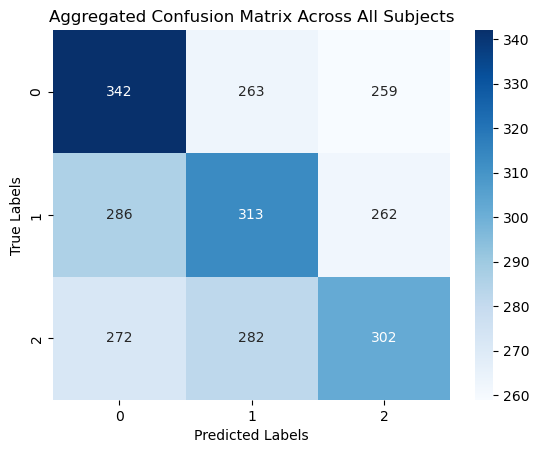

0.36484727124496136


In [142]:
from sklearn.model_selection import GroupKFold, GridSearchCV, check_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score
import numpy as np
import pandas as pd
from warnings import simplefilter
overall_results = []
confusion_matrices = []
cuetype = 'high_cue'
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                    (npspos_dACCdf['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                (npspos_dACCdf['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    groups, _ = pd.factorize(df_sub['run'])
    
    # Define cross-validation at the subject level
    cv = GroupKFold(n_splits=len(np.unique(groups)))  # Or any other number of splits
    cv_splits = cv.split(X, Y, groups)
    
    sub_predictions = []
    sub_true = []
    sub_scores = []
    
    # Outer loop for manual cross-validation
    for train_idx, test_idx in cv_splits:
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced'), 
                                   param_grid, scoring=scoring, refit='Accuracy', cv=len(np.unique(groups)))
        grid_search.fit(X_train, Y_train)
        
        # Best model prediction
        Y_pred = grid_search.predict(X_test)
        
        # Store predictions and true values
        sub_predictions.extend(Y_pred)
        sub_true.extend(Y_test)
        
        # Store the best score
        sub_scores.append(grid_search.best_score_)
        
    # Compute accuracy for this subject using the collected predictions
    sub_accuracy = accuracy_score(sub_true, sub_predictions)
    
    # Append results for this subject
    overall_results.append({
        'sub': sub,
        'accuracy': sub_accuracy,
        
        'best_score_avg': np.mean(sub_scores),
        'y_true': sub_true,
        'y_pred': sub_predictions
    })
    
    # Compute and store confusion matrix for this subject
    cm = confusion_matrix(sub_true, sub_predictions)
    confusion_matrices.append({'sub': sub, 'confusion_matrix': cm})

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
confusion_df = pd.DataFrame(confusion_matrices)

print(results_df)

# confusion matrix______________________________________________________________
aggregate_cm = np.zeros_like(confusion_matrices[0]['confusion_matrix'])

# Sum up all individual confusion matrices
for cm_dict in confusion_matrices:
    aggregate_cm += cm_dict['confusion_matrix']

print("Aggregated Confusion Matrix:")
print(aggregate_cm)
sns.heatmap(aggregate_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Aggregated Confusion Matrix Across All Subjects')
plt.show()

print(results_df.accuracy.mean())


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in 

         sub  accuracy  best_score_avg  \
0   sub-0005  0.291667        0.268519   
1   sub-0013  0.416667        0.306250   
2   sub-0014  0.250000        0.378125   
3   sub-0015  0.250000        0.416667   
4   sub-0016  0.481481        0.383333   
..       ...       ...             ...   
90  sub-0129  0.371429        0.352667   
91  sub-0130  0.416667        0.427333   
92  sub-0131  0.333333        0.444444   
93  sub-0132  0.190476        0.296875   
94  sub-0133  0.388889        0.489333   

                                               y_true  \
0   [0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 2, 2, 0, 1, ...   
1   [0, 1, 2, 1, 0, 2, 1, 2, 1, 0, 0, 2, 1, 1, 0, ...   
2   [2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1, 1, 0, 0, ...   
3                [0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 1, 2]   
4   [0, 1, 0, 0, 0, 2, 1, 2, 2, 1, 0, 0, 1, 2, 2, ...   
..                                                ...   
90  [1, 0, 1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 0, 0, 2, ...   
91  [0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 2, 2

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(


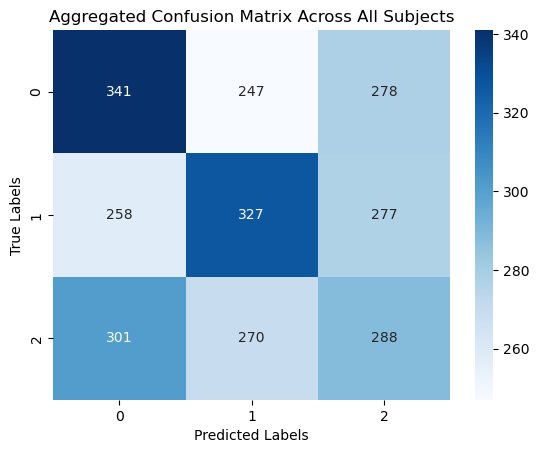

0.3601922098605182


In [210]:
from sklearn.model_selection import GroupKFold, GridSearchCV, check_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score
import numpy as np
import pandas as pd
from warnings import simplefilter
overall_results = []
confusion_matrices = []
cuetype = 'low_cue'
high_cue_pain_index = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                    # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                    (npspos_dACCdf['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACCdf[(npspos_dACCdf['runtype'] == 'pain') & 
                                # ((npspos_dACCdf['ses'] == 'ses-03')) &
                                (npspos_dACCdf['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dACCdf['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    groups, _ = pd.factorize(df_sub['run'])
    
    # Define cross-validation at the subject level
    cv = GroupKFold(n_splits=len(np.unique(groups)))  # Or any other number of splits
    cv_splits = cv.split(X, Y, groups)
    
    sub_predictions = []
    sub_true = []
    sub_scores = []
    
    # Outer loop for manual cross-validation
    for train_idx, test_idx in cv_splits:
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced'), 
                                   param_grid, scoring=scoring, refit='Accuracy', cv=len(np.unique(groups)))
        grid_search.fit(X_train, Y_train)
        
        # Best model prediction
        Y_pred = grid_search.predict(X_test)
        
        # Store predictions and true values
        sub_predictions.extend(Y_pred)
        sub_true.extend(Y_test)
        
        # Store the best score
        sub_scores.append(grid_search.best_score_)
        
    # Compute accuracy for this subject using the collected predictions
    sub_accuracy = accuracy_score(sub_true, sub_predictions)
    
    # Append results for this subject
    overall_results.append({
        'sub': sub,
        'accuracy': sub_accuracy,
        'best_score_avg': np.mean(sub_scores),
        'y_true': sub_true,
        'y_pred': sub_predictions
    })
    
    # Compute and store confusion matrix for this subject
    cm = confusion_matrix(sub_true, sub_predictions)
    confusion_matrices.append({'sub': sub, 'confusion_matrix': cm})

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
confusion_df = pd.DataFrame(confusion_matrices)

print(results_df)

# confusion matrix______________________________________________________________
aggregate_cm = np.zeros_like(confusion_matrices[0]['confusion_matrix'])

# Sum up all individual confusion matrices
for cm_dict in confusion_matrices:
    aggregate_cm += cm_dict['confusion_matrix']

print("Aggregated Confusion Matrix:")
print(aggregate_cm)
sns.heatmap(aggregate_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Aggregated Confusion Matrix Across All Subjects')
plt.show()

print(results_df.accuracy.mean())
